# Handwritten Digits Generation
#### Developed by Swattik Kundu, Computer Science Student of UEMK!
A Generative Adversarial Network(GAN) based project to generate handwritten digits with MNIST dataset. This project is developed using PyTorch, guided by the Coursera Guided Projects Network.

P.S. - I am a beginner and would appreciate any recommendations, thoughts and advise. 

Reach out to/Follow me on:
1. Email - swattik567@gmail.com
2. Github - https://github.com/swattix
3. linkedIn - https://www.linkedin.com/in/swattik-kundu/

### Importing the Dependancies

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms as T
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torch import nn
from torchsummary import summary
from tqdm.notebook import tqdm

### Configurations

In [2]:
device = 'cuda'
batch_size = 128
noise_dim = 64

#Optimizing Parameters
lr = 0.0002
beta_1 = 0.5
beta_2 = 0.99

#Training Variables 
epochs = 20

### Downloading the MNIST dataset

In [3]:
train_augs = T.Compose([
    T.RandomRotation((-20, +20)),
    T.ToTensor()
])

In [4]:
trainset = datasets.MNIST('MNIST/', download=True, train=True, transform=train_augs)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting MNIST/MNIST\raw\train-images-idx3-ubyte.gz to MNIST/MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting MNIST/MNIST\raw\train-labels-idx1-ubyte.gz to MNIST/MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting MNIST/MNIST\raw\t10k-images-idx3-ubyte.gz to MNIST/MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting MNIST/MNIST\raw\t10k-labels-idx1-ubyte.gz to MNIST/MNIST\raw



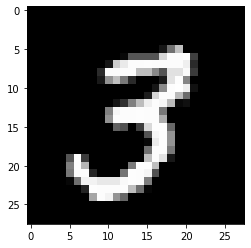

In [5]:
image, label = trainset[6497]
plt.imshow(image.squeeze(), cmap='gray')
plt.show()

In [6]:
print('Total no. of images present in trainset are:', len(trainset))

Total no. of images present in trainset are: 60000


### Load Data into Batches

In [7]:
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [8]:
print('Total no. of batches in TrainLoader :', len(trainloader))

Total no. of batches in TrainLoader : 469


In [9]:
dataiter = iter(trainloader)
images, _ = dataiter.next()
images.shape

torch.Size([128, 1, 28, 28])

In [10]:
#function used to plot some of the images from the batch

def show_tensor_images(tensor_img, num_images=16, size=(1, 28, 28)):
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_images], nrow=4)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()

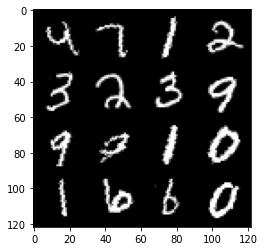

In [11]:
show_tensor_images(images, num_images=16)

### Creating Discriminator Network

In [12]:
def get_disc_layer(in_channels, out_channels, kernel_size, stride):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(0.2)
    )

In [13]:
class Discriminator(nn.Module):

    def __init__(self):
        super(Discriminator, self).__init__()

        self.layer_1 = get_disc_layer(1, 16, (3,3), 2)
        self.layer_2 = get_disc_layer(16, 32, (5,5), 2)
        self.layer_3 = get_disc_layer(32, 64, (5,5), 2)

        self.flatten = nn.Flatten()
        self.linear = nn.Linear(in_features=64, out_features=1)

    def forward(self, images):
        x1 = self.layer_1(images)
        x2 = self.layer_2(x1)
        x3 = self.layer_3(x2)

        x4 = self.flatten(x3)
        x5 = self.linear(x4)

        return x5

In [14]:
D = Discriminator()
D.to(device)

summary(D, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 13, 13]             160
       BatchNorm2d-2           [-1, 16, 13, 13]              32
         LeakyReLU-3           [-1, 16, 13, 13]               0
            Conv2d-4             [-1, 32, 5, 5]          12,832
       BatchNorm2d-5             [-1, 32, 5, 5]              64
         LeakyReLU-6             [-1, 32, 5, 5]               0
            Conv2d-7             [-1, 64, 1, 1]          51,264
       BatchNorm2d-8             [-1, 64, 1, 1]             128
         LeakyReLU-9             [-1, 64, 1, 1]               0
          Flatten-10                   [-1, 64]               0
           Linear-11                    [-1, 1]              65
Total params: 64,545
Trainable params: 64,545
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

Creating Generator Network

In [15]:
def get_gen_layer(in_channels, out_channels, kernel_size, stride, final_block=False):
    if final_block == True:
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
            nn.Tanh()
        )

    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )

In [16]:
class Generator(nn.Module):

    def __init__(self, noise_dim):
        super(Generator, self).__init__()

        self.layer_1 = get_gen_layer(noise_dim, 256, (3,3), 2)
        self.layer_2 = get_gen_layer(256, 128, (4,4), 1)
        self.layer_3 = get_gen_layer(128, 64, (3,3), 2)

        self.layer_4 = get_gen_layer(64, 1, (4,4), 2, final_block=True)

    def forward(self, rand_noise_vec):

        #(batch_size, noise_dim) -> (batch_size, noise_dim, 1, 1)
        x = rand_noise_vec.view(-1, noise_dim, 1, 1)

        x1 = self.layer_1(x)
        x2 = self.layer_2(x1)
        x3 = self.layer_3(x2)
        x4 = self.layer_4(x3)

        return x4

In [17]:
G = Generator(noise_dim)
G.to(device)

summary(G, input_size=(1, noise_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         147,712
       BatchNorm2d-2            [-1, 256, 3, 3]             512
              ReLU-3            [-1, 256, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 6, 6]         524,416
       BatchNorm2d-5            [-1, 128, 6, 6]             256
              ReLU-6            [-1, 128, 6, 6]               0
   ConvTranspose2d-7           [-1, 64, 13, 13]          73,792
       BatchNorm2d-8           [-1, 64, 13, 13]             128
              ReLU-9           [-1, 64, 13, 13]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           1,025
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 747,841
Trainable params: 747,841
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

### Replacing Random Initialized weights to Normal weights to get robust training

In [18]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

In [19]:
D = D.apply(weights_init)
G = G.apply(weights_init)

### Creating the Loss Function(Cost Function) 

In [20]:
def real_loss(disc_pred):
    criterion = nn.BCEWithLogitsLoss()  #takes the raw input without sigmoid activation
    ground_truth = torch.ones_like(disc_pred)
    loss = criterion(disc_pred, ground_truth)
    return loss

def fake_loss(disc_pred):
    criterion = nn.BCEWithLogitsLoss()  #takes the raw input without sigmoid activation
    ground_truth = torch.zeros_like(disc_pred)
    loss = criterion(disc_pred, ground_truth)
    return loss

### Loading the Optimizers

In [21]:
D_opt = torch.optim.Adam(D.parameters(), lr=lr, betas=(beta_1, beta_2))
G_opt = torch.optim.Adam(G.parameters(), lr=lr, betas=(beta_1, beta_2))

### Training Loop

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 1 | Disc_loss: 0.6847848085198067 | Gen_loss: 0.7014277649840821


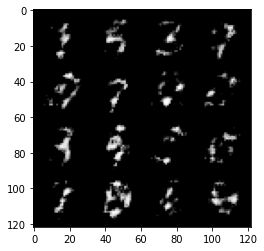

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 2 | Disc_loss: 0.6637775303204176 | Gen_loss: 0.7286006523602044


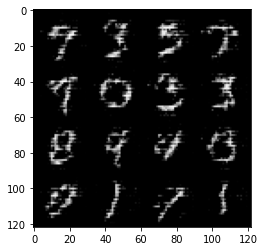

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 3 | Disc_loss: 0.5948946519192856 | Gen_loss: 0.815947167527701


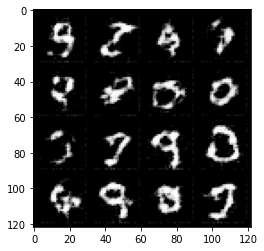

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 4 | Disc_loss: 0.536733883466802 | Gen_loss: 0.9069699781027429


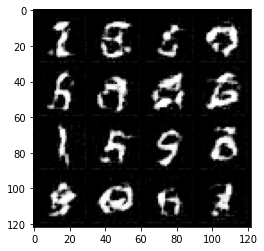

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 5 | Disc_loss: 0.4956086016158814 | Gen_loss: 0.9972425150210416


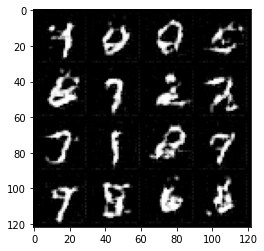

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 6 | Disc_loss: 0.4756249516630478 | Gen_loss: 1.0665645716286927


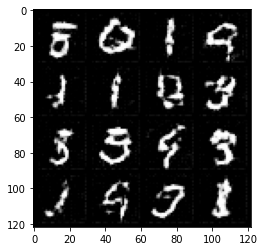

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 7 | Disc_loss: 0.4673314512030148 | Gen_loss: 1.113737287297686


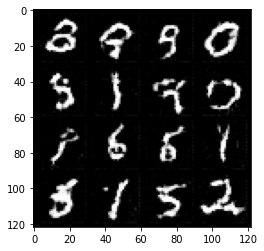

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 8 | Disc_loss: 0.46941420435905457 | Gen_loss: 1.1377413308442528


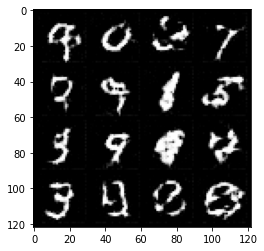

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 9 | Disc_loss: 0.48309806167189756 | Gen_loss: 1.1362582605276534


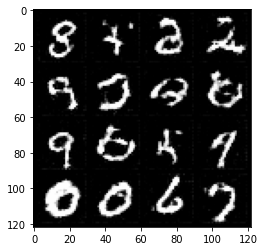

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 10 | Disc_loss: 0.49796754363249107 | Gen_loss: 1.1194531227479865


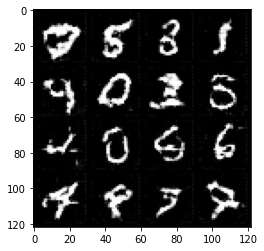

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 11 | Disc_loss: 0.5134471814388405 | Gen_loss: 1.104192768078623


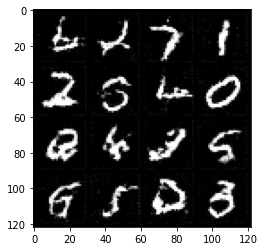

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 12 | Disc_loss: 0.5279998803443746 | Gen_loss: 1.0781028372392472


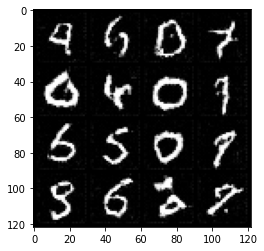

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 13 | Disc_loss: 0.5381064523003503 | Gen_loss: 1.0598193159235565


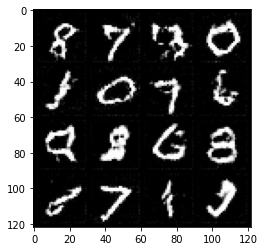

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 14 | Disc_loss: 0.5459790809322268 | Gen_loss: 1.042103156352094


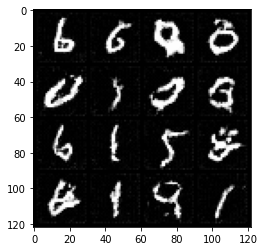

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 15 | Disc_loss: 0.5597211010674678 | Gen_loss: 1.0244606288511362


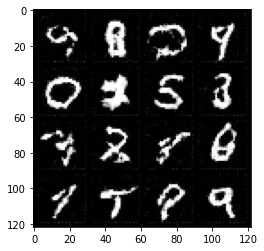

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 16 | Disc_loss: 0.5677781721422159 | Gen_loss: 1.0028343470111838


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


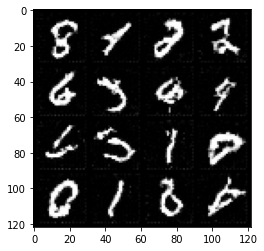

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 17 | Disc_loss: 0.5754559290434506 | Gen_loss: 0.9933058066662949


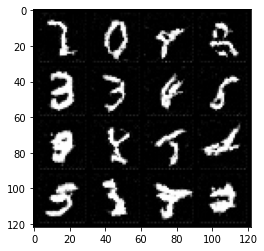

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 18 | Disc_loss: 0.5816158455317971 | Gen_loss: 0.9802068956116877


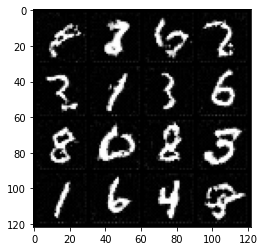

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 19 | Disc_loss: 0.587248033806205 | Gen_loss: 0.9655809377048061


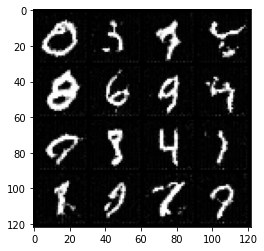

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 20 | Disc_loss: 0.5925456679451948 | Gen_loss: 0.9537753458978779


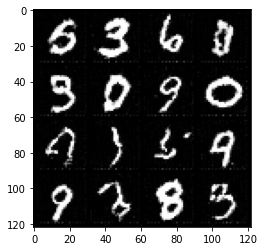

In [22]:
for i in range(epochs):
    total_d_loss = 0.0
    total_g_loss = 0.0

    for real_img, _ in tqdm(trainloader):

        real_img = real_img.to(device)
        noise = torch.randn(batch_size, noise_dim, device=device)

        #finding the loss and updating for Discriminator
        D_opt.zero_grad()

        fake_img = G(noise)
        D_pred = D(fake_img)
        D_fake_loss = fake_loss(D_pred)

        D_pred = D(real_img)
        D_real_loss = real_loss(D_pred)

        D_loss = (D_fake_loss + D_real_loss)/2
        
        total_d_loss = total_d_loss + D_loss.item()

        D_loss.backward()
        D_opt.step()

        #finding the loss and updating for Generator
        G_opt.zero_grad()

        noise = torch.randn(batch_size, noise_dim, device=device)

        fake_img = G(noise)
        D_pred = D(fake_img)
        G_loss = real_loss(D_pred)

        total_g_loss = total_g_loss + G_loss.item()

        G_loss.backward()
        G_opt.step()

    avg_d_loss = total_d_loss / len(trainloader)
    avg_g_loss = total_g_loss / len(trainloader)

    print("Epoch: {} | Disc_loss: {} | Gen_loss: {}".format(i+1, avg_d_loss, avg_g_loss))

    show_tensor_images(fake_img)

